##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 神经风格迁移

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/style_transfer"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />在 tensorflow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/zh-cn/tutorials/generative/style_transfer.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />在 Google Colab 上运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/zh-cn/tutorials/generative/style_transfer.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/zh-cn/tutorials/generative/style_transfer.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载此 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://www.tensorflow.org/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

本教程使用深度学习来用其他图像的风格创造一个图像（曾经你是否希望可以像毕加索或梵高一样绘画？）。 这被称为*神经风格转移*，该技术概述于 <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

神经风格迁移是一种优化技术，用于将两个图像——一个*内容*图像和一个*风格参考*图像（如著名画家的一个作品）——混合在一起，使输出的图像看起来像内容图像， 但是用了风格参考图像的风格。

这是通过优化输出图像以匹配内容图像的内容统计数据和风格参考图像的风格统计数据来实现的。 这些统计数据可以使用卷积网络从图像中提取。

例如，我们选取这张乌龟的照片和 Wassily Kandinsky 的作品 7：

<img src="https://github.com/nounotabe/docs/blob/master/site/zh-cn/tutorials/generative/images/Green_Sea_Turtle_grazing_seagrass.jpg?raw=1" style="width: 500px;"/>

[绿海龟照片](https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg) -摄影者： P.Lindgren [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0), 来自 Wikimedia Common

<img src="https://github.com/nounotabe/docs/blob/master/site/zh-cn/tutorials/generative/images/kadinsky.jpg?raw=1" style="width: 500px;"/>


如果 Kandinsky 决定用这种风格来专门描绘这只海龟会是什么样子？ 是否如下图一样？

<img src="https://github.com/nounotabe/docs/blob/master/site/zh-cn/tutorials/generative/images/kadinsky-turtle.png?raw=1" style="width: 500px;"/>


## 配置


### 导入和配置模块

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [4]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

下载图像并选择风格图像和内容图像：

In [5]:
content_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


## 将输入可视化

定义一个加载图像的函数，并将其最大尺寸限制为 512 像素。

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

创建一个简单的函数来显示图像：

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

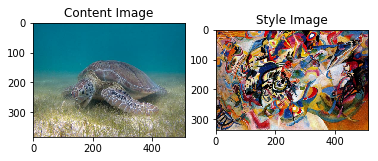

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## 定义内容和风格的表示

使用模型的中间层来获取图像的*内容*和*风格*表示。 从网络的输入层开始，前几个层的激励响应表示边缘和纹理等低级 feature (特征)。 随着层数加深，最后几层代表更高级的 feature (特征)——实体的部分，如*轮子*或*眼睛*。 在此教程中，我们使用的是 VGG19 网络结构，这是一个已经预训练好的图像分类网络。 这些中间层是从图像中定义内容和风格的表示所必需的。 对于一个输入图像，我们尝试匹配这些中间层的相应风格和内容目标的表示。


加载 [VGG19](https://keras.io/applications/#vgg19) 并在我们的图像上测试它以确保正常运行：

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 34s 0us/step


TensorShape([1, 1000])

In [10]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('loggerhead', 0.74297667),
 ('leatherback_turtle', 0.11357909),
 ('hermit_crab', 0.054411974),
 ('terrapin', 0.039235227),
 ('mud_turtle', 0.012614701)]

现在，加载没有分类部分的 `VGG19` ，并列出各层的名称：

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 6s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


从网络中选择中间层的输出以表示图像的风格和内容：


In [12]:
# 内容层将提取出我们的 feature maps （特征图）
content_layers = ['block5_conv2'] 

# 我们感兴趣的风格层
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### 用于表示风格和内容的中间层

那么,为什么我们预训练的图像分类网络中的这些中间层的输出允许我们定义风格和内容的表示？

从高层理解，为了使网络能够实现图像分类（该网络已被训练过），它必须理解图像。 这需要将原始图像作为输入像素并构建内部表示，这个内部表示将原始图像像素转换为对图像中存在的 feature (特征)的复杂理解。

这也是卷积神经网络能够很好地推广的一个原因：它们能够捕获不变性并定义类别（例如猫与狗）之间的 feature (特征)，这些 feature (特征)与背景噪声和其他干扰无关。 因此，将原始图像传递到模型输入和分类标签输出之间的某处的这一过程，可以视作复杂的 feature (特征)提取器。通过这些模型的中间层，我们就可以描述输入图像的内容和风格。

## 建立模型 

使用`tf.keras.applications`中的网络可以让我们非常方便的利用Keras的功能接口提取中间层的值。

在使用功能接口定义模型时，我们需要指定输入和输出：

`model = Model(inputs, outputs)`

以下函数构建了一个 VGG19 模型，该模型返回一个中间层输出的列表：

In [13]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # 加载我们的模型。 加载已经在 imagenet 数据上预训练的 VGG 
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

然后建立模型：

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#查看每层输出的统计信息
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



## 风格计算

图像的内容由中间 feature maps (特征图)的值表示。

事实证明，图像的风格可以通过不同 feature maps (特征图)上的平均值和相关性来描述。 通过在每个位置计算 feature (特征)向量的外积，并在所有位置对该外积进行平均,可以计算出包含此信息的 Gram 矩阵。 对于特定层的 Gram 矩阵，具体计算方法如下所示：

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

这可以使用`tf.linalg.einsum`函数来实现：

In [15]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 提取风格和内容


构建一个返回风格和内容张量的模型。

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

在图像上调用此模型，可以返回 style_layers 的 gram 矩阵（风格）和 content_layers 的内容：

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.034881677
    max:  26723.18
    mean:  780.96204

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  95840.37
    mean:  11674.933

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  296185.97
    mean:  7241.375

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3164085.0
    mean:  104884.49

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  66307.836
    mean:  650.05994

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  939.0783
    mean:  8.983593


## 梯度下降

使用此风格和内容提取器，我们现在可以实现风格传输算法。我们通过计算每个图像的输出和目标的均方误差来做到这一点，然后取这些损失值的加权和。

设置风格和内容的目标值：

In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

定义一个 `tf.Variable` 来表示要优化的图像。 为了快速实现这一点，使用内容图像对其进行初始化（ `tf.Variable` 必须与内容图像的形状相同）

In [19]:
image = tf.Variable(content_image)

由于这是一个浮点图像，因此我们定义一个函数来保持像素值在 0 和 1 之间：

In [20]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

创建一个 optimizer 。 本教程推荐 LBFGS，但 `Adam` 也可以正常工作：

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

为了优化它，我们使用两个损失的加权组合来获得总损失：

In [22]:
style_weight=1e-2
content_weight=1e4

In [23]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

使用 `tf.GradientTape` 来更新图像。

In [24]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

现在，我们运行几个步来测试一下：

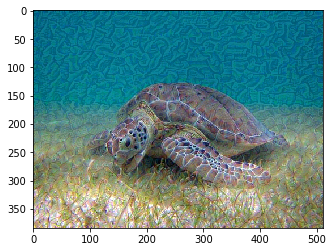

In [25]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

运行正常，我们来执行一个更长的优化：

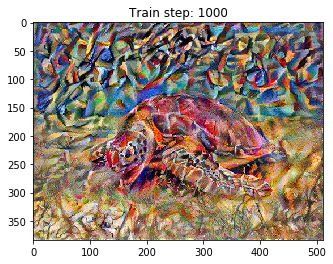

Total time: 21.5


In [26]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

## 总变分损失

此实现只是一个基础版本，它的一个缺点是它会产生大量的高频误差。 我们可以直接通过正则化图像的高频分量来减少这些高频误差。 在风格转移中，这通常被称为*总变分损失*：

In [27]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

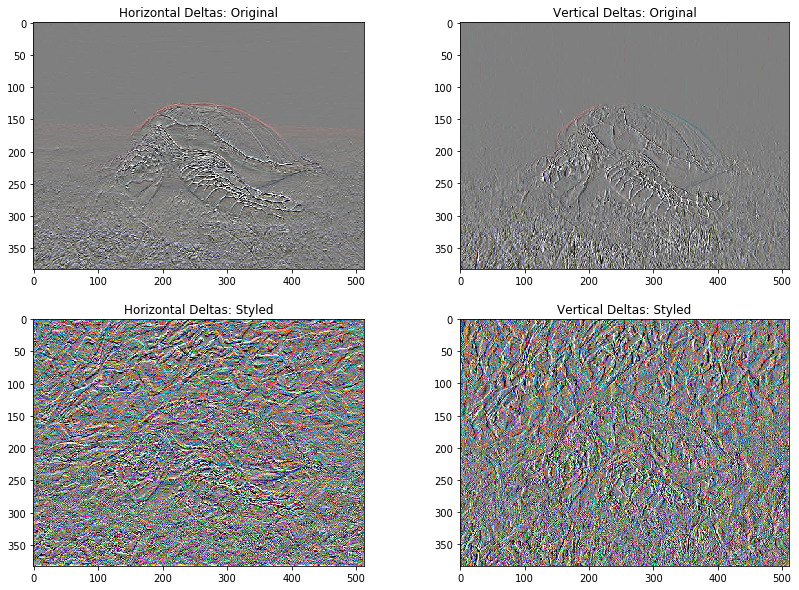

In [28]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

这显示了高频分量如何增加。

而且，本质上高频分量是一个边缘检测器。 我们可以从 Sobel 边缘检测器获得类似的输出，例如：

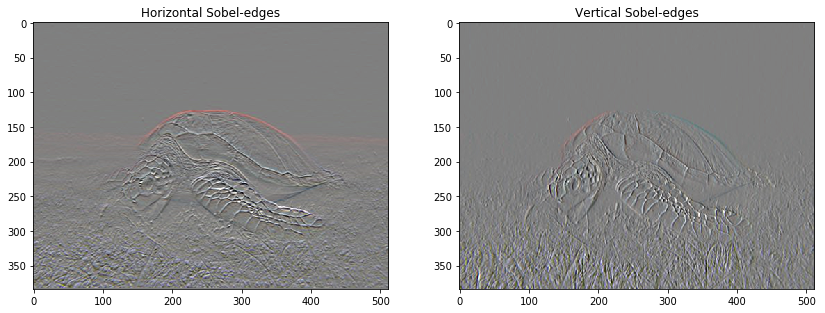

In [29]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

与此相关的正则化损失是这些值的平方和：

In [30]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

## 重新进行优化

选择 `total_variation_loss` 的权重：

In [31]:
total_variation_weight=1e8

现在，将它加入 `train_step` 函数中：

In [32]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

重新初始化优化的变量：

In [33]:
image = tf.Variable(content_image)

并进行优化：

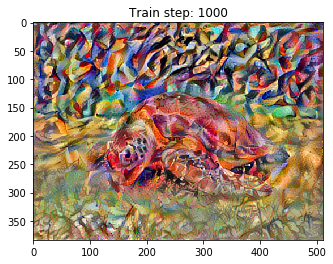

Total time: 22.8


In [34]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

最后，保存结果：

In [35]:
file_name = 'kadinsky-turtle.png'
mpl.image.imsave(file_name, image[0])

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)